2.6.0
Number of images: 3670


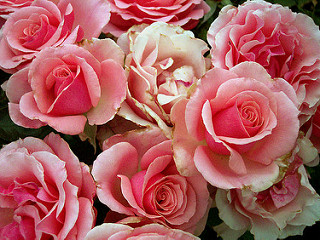

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)

# download the dataset
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# .glob() returns an object of a list of files with the given syntax
# convert to a list to access that list
image_count = len(list(data_dir.glob("*/*.jpg")))

print (f"Number of images: {image_count}")


roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))


In [2]:
# load in the data we downloaded using Keras
batch_size = 32
img_height = 180
img_width = 180
# create training dataset
# training dataset alters the weights and biases of the model
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [3]:
# create validation dataset
# validation training set used at the end of each epoch to evaluate
# the accuracy of the model
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


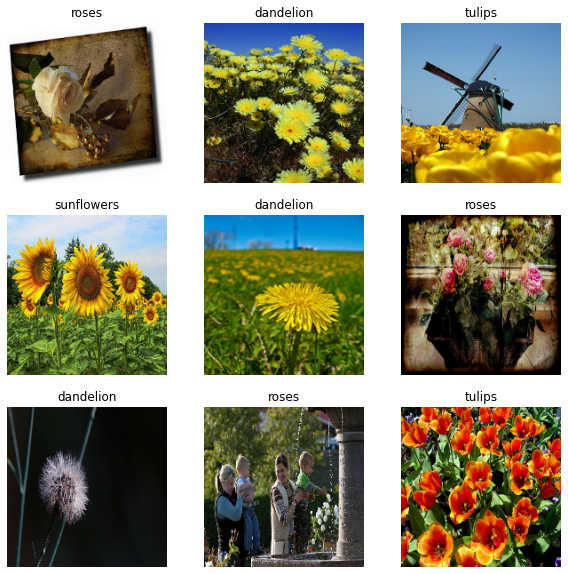

In [5]:
# visualizing the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [7]:
# conditioning datasets for performance (prevent I/O blocking)
# Dataset.cache keeps images in memory after they're loaded during the first epoch
# Dataset.pregetch overlaps data preprocessing and model execucution during training
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# standardize the [0,255] RGB values to [0,1] 
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:

# number of classes in our classification list
# ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
num_classes = 5

# example sequential model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [10]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [12]:

# TRAINING THE MODEL
epochs=10 # number of times dataset will be sent through model

# train the model with train_ds training dataset,
# val_ds validation dataset,
# for the number of epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 32s 342ms/step - loss: 1.4488 - accuracy: 0.3968 - val_loss: 1.1367 - val_accuracy: 0.5450
Epoch 2/10
92/92 [==============================] - 33s 362ms/step - loss: 1.0269 - accuracy: 0.5906 - val_loss: 1.0152 - val_accuracy: 0.5804
Epoch 3/10
92/92 [==============================] - 36s 394ms/step - loss: 0.8523 - accuracy: 0.6785 - val_loss: 0.9050 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 31s 338ms/step - loss: 0.7130 - accuracy: 0.7367 - val_loss: 0.9095 - val_accuracy: 0.6458
Epoch 5/10
92/92 [==============================] - 29s 318ms/step - loss: 0.5134 - accuracy: 0.8076 - val_loss: 0.9603 - val_accuracy: 0.6649
Epoch 6/10
92/92 [==============================] - 29s 315ms/step - loss: 0.3143 - accuracy: 0.8927 - val_loss: 0.9470 - val_accuracy: 0.6907
Epoch 7/10
92/92 [==============================] - 36s 392ms/step - loss: 0.1686 - accuracy: 0.9465 - val_loss: 1.1381 - val_accuracy: 0.6662

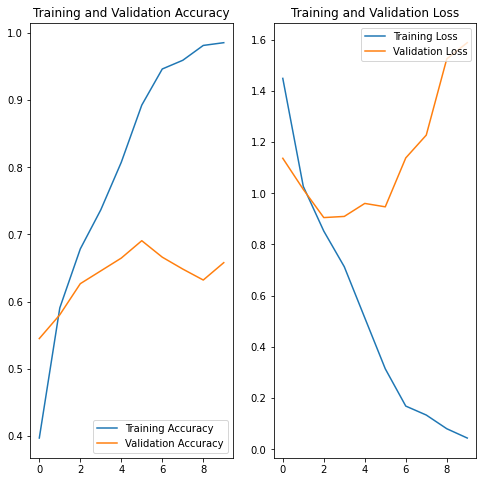

In [13]:
# create plots of the loss and accuracy of the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# Data Augmentation: taking the images from the training dataset and
# augmenting them (flip, rotate, zoom) to create new training images
# We create a new layer that augments those images

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

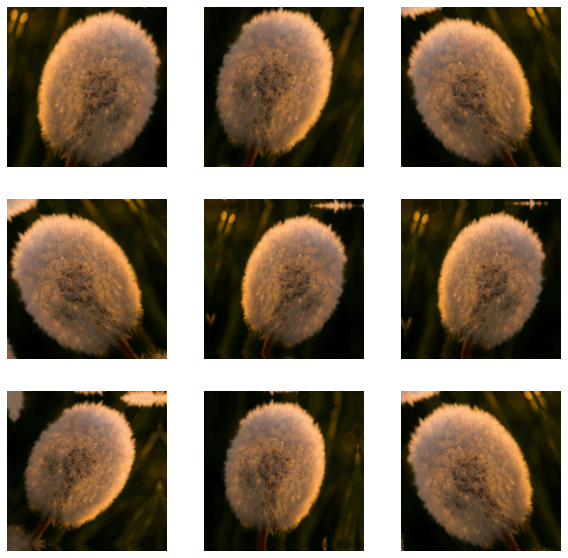

In [15]:
# Visualizing these newly generated images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
# new Sequential model that includes the augmentation layer and
# the dropout layer to prevent overfitting

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [18]:
# RETRAINING THE UPDATED MODEL
# increase the number of epochs
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# # save out entire model as a SavedModel
# !mkdir -p saved_model
# model.save("saved_model/saved_tutorialmodel")

Epoch 1/15
92/92 [==============================] - 34s 365ms/step - loss: 1.3418 - accuracy: 0.4281 - val_loss: 1.0844 - val_accuracy: 0.5695
Epoch 2/15
92/92 [==============================] - 33s 362ms/step - loss: 1.0689 - accuracy: 0.5630 - val_loss: 0.9884 - val_accuracy: 0.6117
Epoch 3/15
92/92 [==============================] - 34s 366ms/step - loss: 0.9757 - accuracy: 0.6155 - val_loss: 0.9284 - val_accuracy: 0.6458
Epoch 4/15
92/92 [==============================] - 35s 382ms/step - loss: 0.8672 - accuracy: 0.6662 - val_loss: 0.9334 - val_accuracy: 0.6458
Epoch 5/15
92/92 [==============================] - 34s 373ms/step - loss: 0.8283 - accuracy: 0.6805 - val_loss: 0.8256 - val_accuracy: 0.6703
Epoch 6/15
92/92 [==============================] - 33s 364ms/step - loss: 0.7787 - accuracy: 0.7071 - val_loss: 0.8376 - val_accuracy: 0.6662
Epoch 7/15
92/92 [==============================] - 33s 362ms/step - loss: 0.6998 - accuracy: 0.7296 - val_loss: 0.8017 - val_accuracy: 0.6853

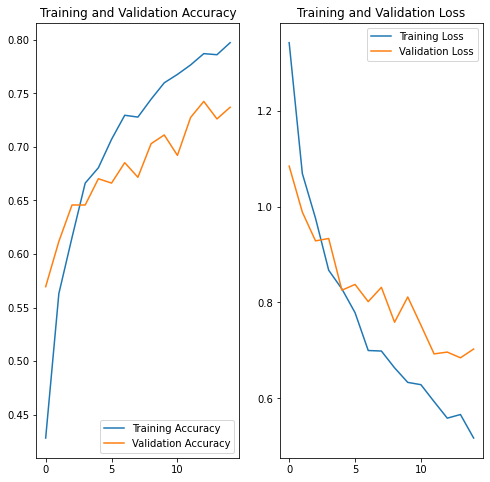

In [19]:
# plots of the loss and accurace on the NEW model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

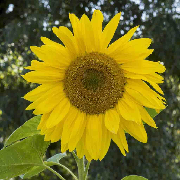

This image most likely belongs to sunflowers with a 79.51 percent confidence.


In [24]:
# with our trained model, let's classify an image that wasn't in
# our training or validation sets

# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    'sunf.jpg', target_size=(img_height, img_width)
)
img.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [22]:
print(np.argmax(score))

3


In [25]:
!mkdir -p saved_model
model.save("saved_model/saved_tutorialmodel")

INFO:tensorflow:Assets written to: saved_model/saved_tutorialmodel/assets
